In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)
library(tidyr)
library(RColorBrewer)
library(gridExtra)
library(stats)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###This file is from the [make l2fc notebook](./Sparsity_make_l2fc_table.ipynb)

In [5]:
%%R

sample.data = read.table("data/l2fc_table.csv",
                         sep = ",", header = TRUE)
#sample.data$treatment = as.character(sample.data$treatment)
head(sample.data)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [34]:
%%R
d = sample.data %>% 
    select(OTU, Treatment, log2FoldChange, Day) #%>% 
    #spread(Treatment, log2FoldChange)

#d$Treatment[d$Treatment == "13CC"] = "13C - Cellulose.only"
#d$Treatment[d$Treatment == "12CC"] = "Control - Cellulose.only"
#d$Treatment[d$Treatment == "13C100"] = "13C - RE.continuous"
#d$Treatment[d$Treatment == "12C100"] = "Control - RE.continuous"
#d$Treatment[d$Treatment == "13C700"] = "13C - RE.single"
#d$Treatment[d$Treatment == "12C700"] = "Control - RE.single"
sample.data$Treatment = as.character(sample.data$Treatment)
head(d)

       OTU Treatment log2FoldChange Day
1 OTU.4204      13CC    -0.20588818  14
2  OTU.467      13CC    -0.30402392  14
3  OTU.905      13CC     0.08372895  14
4 OTU.7253      13CC     0.12803079  14
5   OTU.67      13CC    -0.52084841  14
6 OTU.4907      13CC     0.14386449  14


In [69]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df1.14 = subset(d, Treatment %in% c("13CC", "13C100") & Day == "14")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df1.14 = df1.14 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.14)[3] = "C13.100"
colnames(df1.14)[4] = "C13.Cellulose.only"
head(df1.14)

       OTU Day    C13.100 C13.Cellulose.only
1    OTU.1  14 -0.2754702       2.0213679844
2   OTU.10  14  2.5840326       3.3105564643
3  OTU.100  14 -1.8163298      -1.4913293087
4 OTU.1000  14 -1.4922032       0.0008708716
5 OTU.1001  14         NA      -0.3776608511
6 OTU.1002  14         NA       0.2975036307


In [55]:
%%R 
#this is to make an x,y data frame of l2fc at day 28
df1.28 = subset(d, Treatment %in% c("13CC", "13C100") & Day == "28")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df1.28 = df1.28 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.28)[3] = "C13.100"
colnames(df1.28)[4] = "C13.Cellulose.only"
head(df1.28)

       OTU Day    C13.100 C13.Cellulose.only
1    OTU.1  28 -1.2710153          0.9099756
2   OTU.10  28  3.2116725          1.9391412
3  OTU.100  28 -2.2613347         -0.5463697
4 OTU.1000  28 -0.9828252         -0.2080464
5 OTU.1001  28 -0.8489683         -0.1940110
6 OTU.1002  28  0.9264426         -0.4073470


In [56]:
%%R 
#this is to make an x,y data frame of l2fc at day 45
df1.45 = subset(d, Treatment %in% c("13CC", "13C100") & Day == "45")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df1.45 = df1.45 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.45)[3] = "C13.100"
colnames(df1.45)[4] = "C13.Cellulose.only"
head(df1.45)

       OTU Day    C13.100 C13.Cellulose.only
1    OTU.1  45 -0.4112294          1.1108168
2   OTU.10  45  2.9204350          3.1312454
3  OTU.100  45 -1.0751864         -0.7901756
4 OTU.1000  45  0.1115000         -1.0266382
5 OTU.1001  45 -0.2522925          1.3857312
6 OTU.1002  45  1.2177801          0.6351137


NULL


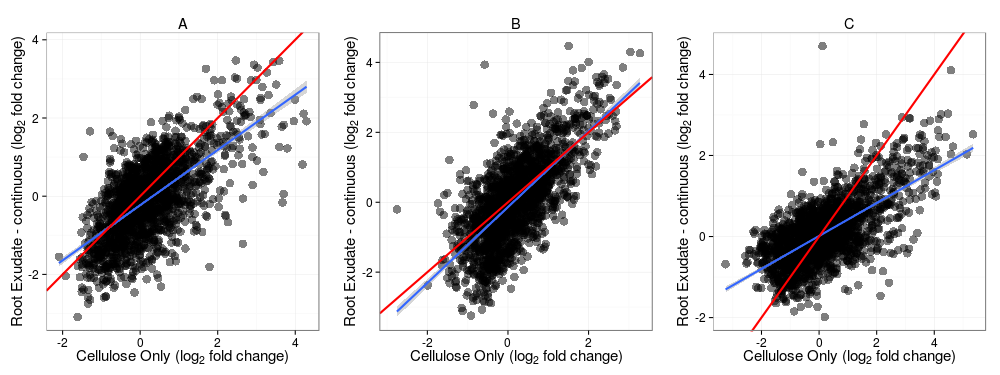

In [71]:
%%R -w 1000 -h 375

p1 = ggplot(df1.14, aes(x = C13.Cellulose.only, y = C13.100))
p1 = p1 + geom_point(alpha = 0.5, size = 4)
p1 = p1 + stat_smooth(method = "lm", size = 1)
p1 = p1 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - continuous (", log[2]," fold change)",sep=""))
               )
p1 = p1 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p1 = p1 + ggtitle("A")
p1 = p1 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p1 = p1 + theme_bw()
p1 = p1 + theme(axis.title.x = element_text(size=15))
p1 = p1 + theme(axis.title.y = element_text(size=15))
p1 = p1 + theme(axis.text.x = element_text(size=12))
p1 = p1 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p2 = ggplot(df1.28, aes(x = C13.Cellulose.only, y = C13.100))
p2 = p2 + geom_point(alpha = 0.5, size = 4)
p2 = p2 + stat_smooth(method = "lm", size = 1)
p2 = p2 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - continuous (", log[2]," fold change)",sep=""))
               )
p2 = p2 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p2 = p2 + ggtitle("B")
p2 = p2 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p2 = p2 + theme_bw()
p2 = p2 + theme(axis.title.x = element_text(size=15))
p2 = p2 + theme(axis.title.y = element_text(size=15))
p2 = p2 + theme(axis.text.x = element_text(size=12))
p2 = p2 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p3 = ggplot(df1.45, aes(x = C13.Cellulose.only, y = C13.100))
p3 = p3 + geom_point(alpha = 0.5, size = 4)
p3 = p3 + stat_smooth(method = "lm", size = 1)
p3 = p3 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - continuous (", log[2]," fold change)",sep=""))
               )
p3 = p3 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p3 = p3 + ggtitle("C")
p3 = p3 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p3 = p3 + theme_bw()
p3 = p3 + theme(axis.title.x = element_text(size=15))
p3 = p3 + theme(axis.title.y = element_text(size=15))
p3 = p3 + theme(axis.text.x = element_text(size=12))
p3 = p3 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)

p.combined = grid.arrange(p1, p2, p3, widths = c(1,1,1), heights = c(1,1,1), ncol = 3)

p.combined



In [73]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.14 = subset(d, Treatment %in% c("13CC", "13C700") & Day == "14")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.14 = df2.14 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.14)[3] = "C13.700"
colnames(df2.14)[4] = "C13.Cellulose.only"
head(df2.14)

       OTU Day    C13.700 C13.Cellulose.only
1    OTU.1  14  0.1432308       2.0213679844
2   OTU.10  14  4.1889022       3.3105564643
3  OTU.100  14 -2.3441972      -1.4913293087
4 OTU.1000  14 -0.8766583       0.0008708716
5 OTU.1001  14 -0.2054988      -0.3776608511
6 OTU.1002  14  1.3603396       0.2975036307


In [74]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.28 = subset(d, Treatment %in% c("13CC", "13C700") & Day == "28")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.28 = df2.28 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.28)[3] = "C13.700"
colnames(df2.28)[4] = "C13.Cellulose.only"
head(df2.28)

       OTU Day     C13.700 C13.Cellulose.only
1    OTU.1  28  0.41982000          0.9099756
2   OTU.10  28  2.37477270          1.9391412
3  OTU.100  28 -1.91400641         -0.5463697
4 OTU.1000  28 -0.06627435         -0.2080464
5 OTU.1001  28  0.04379588         -0.1940110
6 OTU.1002  28  1.23094364         -0.4073470


In [75]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.45 = subset(d, Treatment %in% c("13CC", "13C700") & Day == "45")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.45 = df2.45 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.45)[3] = "C13.700"
colnames(df2.45)[4] = "C13.Cellulose.only"
head(df2.45)

       OTU Day    C13.700 C13.Cellulose.only
1    OTU.1  45  0.2916241          1.1108168
2   OTU.10  45  2.7298395          3.1312454
3  OTU.100  45 -2.4027701         -0.7901756
4 OTU.1000  45  0.6109725         -1.0266382
5 OTU.1001  45 -0.6081975          1.3857312
6 OTU.1002  45  1.1148863          0.6351137


NULL


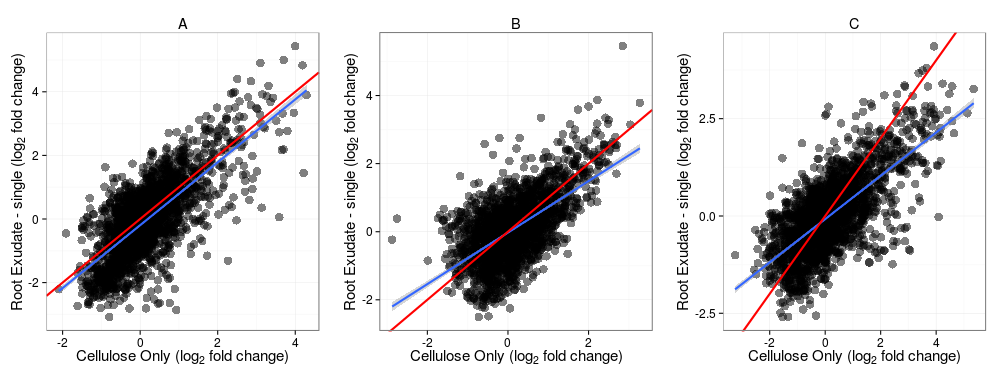

In [76]:
%%R -w 1000 -h 375

p4 = ggplot(df2.14, aes(x = C13.Cellulose.only, y = C13.700))
p4 = p4 + geom_point(alpha = 0.5, size = 4)
p4 = p4 + stat_smooth(method = "lm", size = 1)
p4 = p4 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - single (", log[2]," fold change)",sep=""))
               )
p4 = p4 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p4 = p4 + ggtitle("A")
p4 = p4 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p4 = p4 + theme_bw()
p4 = p4 + theme(axis.title.x = element_text(size=15))
p4 = p4 + theme(axis.title.y = element_text(size=15))
p4 = p4 + theme(axis.text.x = element_text(size=12))
p4 = p4 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p5 = ggplot(df2.28, aes(x = C13.Cellulose.only, y = C13.700))
p5 = p5 + geom_point(alpha = 0.5, size = 4)
p5 = p5 + stat_smooth(method = "lm", size = 1)
p5 = p5 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - single (", log[2]," fold change)",sep=""))
               )
p5 = p5 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p5 = p5 + ggtitle("B")
p5 = p5 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p5 = p5 + theme_bw()
p5 = p5 + theme(axis.title.x = element_text(size=15))
p5 = p5 + theme(axis.title.y = element_text(size=15))
p5 = p5 + theme(axis.text.x = element_text(size=12))
p5 = p5 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p6 = ggplot(df2.45, aes(x = C13.Cellulose.only, y = C13.700))
p6 = p6 + geom_point(alpha = 0.5, size = 4)
p6 = p6 + stat_smooth(method = "lm", size = 1)
p6 = p6 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - single (", log[2]," fold change)",sep=""))
               )
p6 = p6 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p6 = p6 + ggtitle("C")
p6 = p6 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p6 = p6 + theme_bw()
p6 = p6 + theme(axis.title.x = element_text(size=15))
p6 = p6 + theme(axis.title.y = element_text(size=15))
p6 = p6 + theme(axis.text.x = element_text(size=12))
p6 = p6 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)

p.combined = grid.arrange(p4, p5, p6, widths = c(1,1,1), heights = c(1,1,1), ncol = 3)

p.combined

